In [4]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# PLOTTING OPTIONS
fig_width_pt = 6*246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean/2.0      # height in inches
fig_size =  [fig_width,fig_height]
params = { 'axes.labelsize': 24,
          'font.family': 'serif',
          'font.serif': 'Computer Modern Raman',
          'font.size': 24,
          'legend.fontsize': 20,
          'xtick.labelsize': 24,
          'ytick.labelsize': 24,
          #'axes.grid' : True,
          'text.usetex': True,
          'savefig.dpi' : 200,
          'lines.markersize' : 14,
          'figure.figsize': fig_size}
mpl.rcParams.update(params)

In [5]:
import os
os.environ['HMR_FILE'] = '../s.hdf'
!pip install gwsurrogate

DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Python 2.7 in January 2021. More details about Python 2 support in pip, can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support
You should consider upgrading via the '/home/ahnitz/projects/hmr/env/bin/python2 -m pip install --upgrade pip' command.


In [6]:
import gwsurrogate as gws

path_to_surrogate = './EMRISur1dq1e4.h5'

setting __package__ to gwsurrogate.new so relative imports work
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new
setting __package__ to gwsurrogate.new so relative imports work
setting __package__ to gwsurrogate.new so relative imports work


/home/ahnitz/projects/hmr/env/lib/python2.7/site-packages/gwtools/rotations.py:63: UserWarning: Could not import GWFrames, needed for rotations module
  _warnings.warn("Could not import GWFrames, needed for rotations module")
/home/ahnitz/projects/hmr/env/lib/python2.7/site-packages/gwtools/__init__.py:11: UserWarning: Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.
  _warnings.warn("Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.")


In [7]:
model = gws.EvaluateSurrogate(path_to_surrogate)

loading surrogate mode... l2_m1

>>> Found surrogate ID from file name: EMRISur1dq1e4

>>> Warning: Guessing quadrature weights to be identical with 0.049805
Cannot load greedy points...OK
Cannot load eim points...OK
Special case: using spline for parametric model at each EI node
spline knots = 41, num_fits = 10
setting norm fitparams to None...
loading surrogate mode... l2_m2

>>> Found surrogate ID from file name: EMRISur1dq1e4

>>> Warning: Guessing quadrature weights to be identical with 0.049805
Cannot load greedy points...OK
Cannot load eim points...OK
Special case: using spline for parametric model at each EI node
spline knots = 41, num_fits = 10
setting norm fitparams to None...
loading surrogate mode... l3_m1

>>> Found surrogate ID from file name: EMRISur1dq1e4

>>> Warning: Guessing quadrature weights to be identical with 0.049805
Cannot load greedy points...OK
Cannot load eim points...OK
Special case: using spline for parametric model at each EI node
spline knots = 41, num_

In [8]:
from pycbc.waveform import get_td_waveform, get_fd_waveform
import pylab

M = 30
q = 3000

from pycbc.conversions import mass1_from_mtotal_q, mass2_from_mtotal_q
m1 = mass1_from_mtotal_q(M, q)
m2 = mass2_from_mtotal_q(M, q)
theta = 1.7
phi = 0
fmin = 290
dist = 1

buff = 128.0
df = 1.0 / buff

import numpy
times = numpy.arange(-10, 1,.001)
times, hp, hc = model(M=M,q=q, dist=dist, theta=0, phi=phi, f_low=fmin)

times4, hp4, hc4 = model(M=M,q=q, dist=dist, theta=1.7, phi=phi, f_low=fmin)

print times4[1] - times4[0]
dt = times[1] - times[0]
sr = 1.0 / dt

tlen = int(sr * buff)
flen = tlen / 2 + 1

print m1, m2
hp2, hc2 = get_fd_waveform(approximant="HMR", mass1=m1, mass2=m2, f_lower=20,
                           delta_f=df, inclination=0)
hp2.resize(flen)
hp2 = hp2.to_timeseries().cyclic_time_shift(5.0)

hp3, hc3 = get_td_waveform(approximant="EOBNRv2", mass1=m1, mass2=m2, f_lower=50,
                           delta_t=dt, inclination=0)

print hp2.duration
hp2.start_time += .0005

7.390976e-06
29.9900033322 0.00999666777741
128.0


17318416 8659209
148830 148830 148830 148830


/home/ahnitz/projects/hmr/env/lib/python2.7/site-packages/matplotlib/font_manager.py:1333: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


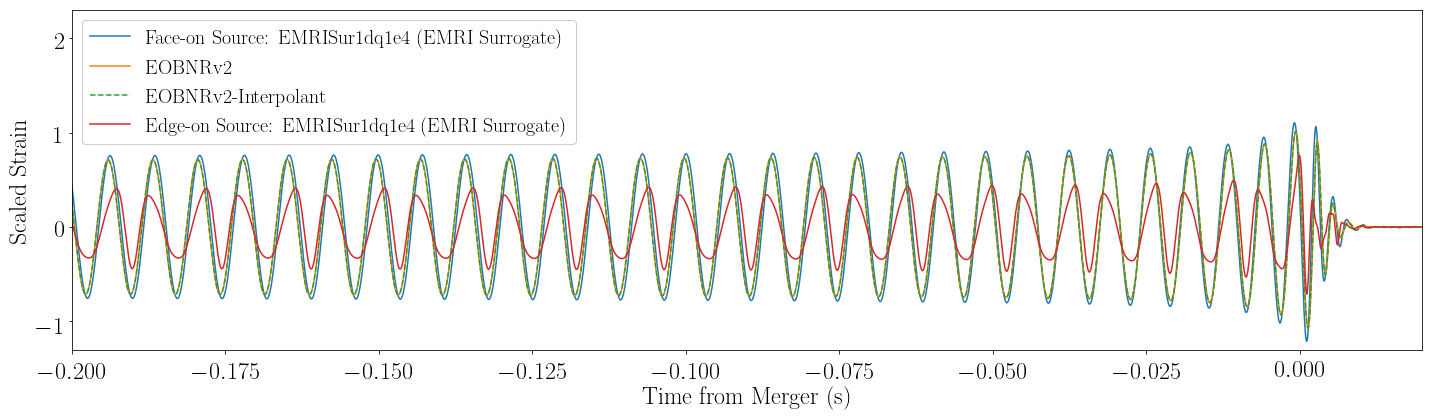

In [9]:
#pylab.rc('text', usetex=True)
from pycbc.types import TimeSeries

hpt = TimeSeries(hp, delta_t=times[1]-times[0], epoch=float(times[0]))
hpt.resize(tlen)
hp4t = TimeSeries(hp4, delta_t=times4[1]-times4[0], epoch=float(times4[0]))
hp4t.resize(tlen)

hp3t = hp3.copy()
hp3t.resize(tlen)
hp2t = hp2.copy()

scale = 0.25 * 1e22
hpt = hpt.time_slice(-1, 0.1) * scale
hp2t = hp2t.time_slice(-1, 0.1) * scale
hp3t = hp3t.time_slice(-1, 0.1) * scale
hp4t = hp4t.time_slice(-1, 0.1) * scale

from pycbc.filter import match, matched_filter
print tlen, flen
print len(hpt), len(hp2t), len(hp3t), len(hp4t)
snr = matched_filter(hpt, hp4t)
snr2 = matched_filter(hp2t, hpt)
snr3 = matched_filter(hp3t, hpt)

i2 = snr2.abs_arg_max()
hp2t.roll(i2)
phi = snr2[i2] / abs(snr2[i2])
hp2t = (hp2t.to_frequencyseries() * phi).to_timeseries()


i3 = snr3.abs_arg_max()
hp3t.roll(i3)
phi = snr3[i3] / abs(snr3[i3])
hp3t = (hp3t.to_frequencyseries() * phi).to_timeseries()


#hp2t.roll(i2)
#hp3t.roll(i3)

#print m, m2, m3, i, i2, i3

#pylab.figure(figsize=[8, 3], dpi=500)
pylab.figure()
pylab.plot(hpt.sample_times, hpt, label='Face-on Source: EMRISur1dq1e4 (EMRI Surrogate)')
pylab.plot(hp3t.sample_times, hp3t, label='EOBNRv2', linestyle='-')
pylab.plot(hp2t.sample_times, hp2t, label='EOBNRv2-Interpolant', linestyle='--')
pylab.plot(hp4t.sample_times, hp4t, label='Edge-on Source: EMRISur1dq1e4 (EMRI Surrogate)')
pylab.ylabel('Scaled Strain')
pylab.xlabel('Time from Merger (s)')
pylab.legend(loc='upper left', framealpha=1.0)
pylab.xlim(-0.2, .02)
pylab.ylim(-1.3, 2.3)
pylab.tight_layout()
pylab.savefig('waveform.pdf')
#pylab.grid()